# Exploratory Data Analysis


## Imports

Add necessary imports.

In [3]:
import pandas as pd
import numpy as np
from collections import Counter # for generating bag of words matrix
from sklearn.cluster import KMeans # for clustering
from sklearn.metrics import silhouette_score # for cluster evaluation
import matplotlib.pyplot as plt # for cluster evaluation
from tqdm.notebook import tqdm  # for Jupyter notebook progress bar
import re
from difflib import get_close_matches
import warnings
warnings.filterwarnings('ignore', message='DataFrame is highly fragmented*')

In [4]:
# Random seed constant
RANDOM_SEED = 42

## Data Loading

Loading our DataFrame.

In [6]:
df = pd.read_csv("battle_data.csv")

## Data Preprocessing

### Removing low value battles

In some battles, users disconnect or forfeit before a significant amount of gameplay has occured. We want to remove those instances from the DataFrame.

The bottom tenth percentile of turns per battle is 4.0 turns. 



<Axes: ylabel='Frequency'>

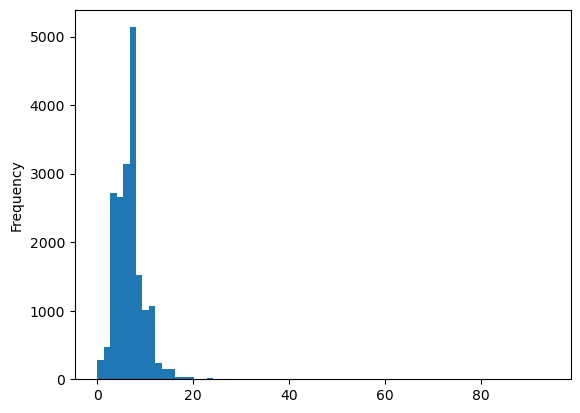

In [9]:
tenth_percentile = df["turn_count"].quantile(0.1)
print(f"The bottom tenth percentile of turns per battle is {tenth_percentile} turns. \n")
df["turn_count"].plot.hist(bins=70)

In [10]:
# Removing battles that have been disconnected or forfeited in 4 turns or fewer.
forfeit_mask = df["forfeit"] == 1
disconnect_mask = df["disconnect"] == 1
low_turn_mask = df["turn_count"] <= 3

df = df[~(forfeit_mask & disconnect_mask & low_turn_mask)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17554 entries, 0 to 18681
Data columns (total 95 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   p1_species_1  17554 non-null  object 
 1   p1_item_1     17549 non-null  object 
 2   p1_ability_1  17554 non-null  object 
 3   p1_move_1_1   17554 non-null  object 
 4   p1_move_1_2   17354 non-null  object 
 5   p1_move_1_3   17354 non-null  object 
 6   p1_move_1_4   17350 non-null  object 
 7   p1_species_2  17554 non-null  object 
 8   p1_item_2     17536 non-null  object 
 9   p1_ability_2  17554 non-null  object 
 10  p1_move_2_1   17554 non-null  object 
 11  p1_move_2_2   17445 non-null  object 
 12  p1_move_2_3   17445 non-null  object 
 13  p1_move_2_4   17442 non-null  object 
 14  p1_species_3  17554 non-null  object 
 15  p1_item_3     17548 non-null  object 
 16  p1_ability_3  17554 non-null  object 
 17  p1_move_3_1   17554 non-null  object 
 18  p1_move_3_2   17480 non-null  o

In [11]:
# Removing rows that have missing data on one or more of the 6 Pokemon slots
name_cols = [col for col in df.columns if "species" in col]
df = df.dropna(axis=0, subset=name_cols)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17402 entries, 0 to 18681
Data columns (total 95 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   p1_species_1  17402 non-null  object 
 1   p1_item_1     17397 non-null  object 
 2   p1_ability_1  17402 non-null  object 
 3   p1_move_1_1   17402 non-null  object 
 4   p1_move_1_2   17202 non-null  object 
 5   p1_move_1_3   17202 non-null  object 
 6   p1_move_1_4   17198 non-null  object 
 7   p1_species_2  17402 non-null  object 
 8   p1_item_2     17386 non-null  object 
 9   p1_ability_2  17402 non-null  object 
 10  p1_move_2_1   17402 non-null  object 
 11  p1_move_2_2   17293 non-null  object 
 12  p1_move_2_3   17293 non-null  object 
 13  p1_move_2_4   17290 non-null  object 
 14  p1_species_3  17402 non-null  object 
 15  p1_item_3     17397 non-null  object 
 16  p1_ability_3  17402 non-null  object 
 17  p1_move_3_1   17402 non-null  object 
 18  p1_move_3_2   17330 non-null  o

## Adding Pokemon Stats and Type Data

We want to add as columns the base stats and typings for each of the Pokemon represented in our data.

Our data source is the public Github repository [pokemonData](https://github.com/lgreski/pokemonData), scraped by Len Greski from the website [Pokemon Database](https://pokemondb.net/). Pokemon base stat and type values / changes are up to date for Generation 9.

### Loading Files

In [15]:
def load_stats_df():
    df_stats = pd.read_csv("poke_stat_type_data.csv")

    # Merging name and form columns
    df_stats["full_name"] = df_stats.apply(lambda df: f"{df['Name']}-{df['Form']}" if len(df["Form"]) > 1 else df["Name"], axis=1).values

    # Making formatting consistent with our main DataFrame
    df_stats.columns = [x.lower().replace("1", "_1").replace("2", "_2").replace(". ", "_") for x in df_stats.columns]

    return df_stats

df_stats = load_stats_df()

df_stats.head()

,id,name,form,type_1,type_2,total,hp,attack,defense,sp_atk,sp_def,speed,generation,full_name
0,1,Bulbasaur,,Grass,Poison,318,45,49,49,65,65,45,1,Bulbasaur
1,2,Ivysaur,,Grass,Poison,405,60,62,63,80,80,60,1,Ivysaur
2,3,Venusaur,,Grass,Poison,525,80,82,83,100,100,80,1,Venusaur
3,4,Charmander,,Fire,,309,39,52,43,60,50,65,1,Charmander
4,5,Charmeleon,,Fire,,405,58,64,58,80,65,80,1,Charmeleon


### Simple Matching Function

The Github CSV splits its naming into Name and Form in two seperate columns. The Showdown data is messier, and often uses shorthands E.g. Indeedee-M instead of Name: Indeedee Form: Male. The below mapping function matches these names by combining the columns, and applying rules to match the name. difflib is used to find closest match in case of no exact match.

In [17]:
# NOTE: With help from GPT 4.1. This was tedious.

def showdown_to_github(showdown_name, github_names):
    # Direct match
    if showdown_name in github_names:
        return showdown_name

    # Split on hyphens
    parts = showdown_name.split('-')
    base = parts[0]

    # Gender
    if showdown_name in ['Indeedee-F', 'Meowstic-F']:
        if showdown_name == 'Indeedee-F' and 'Indeedee-Female' in github_names:
            return 'Indeedee-Female'
        if showdown_name == 'Meowstic-F' and 'Meowstic-Female' in github_names:
            return 'Meowstic-Female'

    if showdown_name in ['Indeedee', 'Meowstic']:
        male = showdown_name + '-Male'
        if male in github_names:
            return male

    # Giratina forms
    if base == 'Giratina':
        if len(parts) == 1 and 'Giratina-Altered Forme' in github_names:
            return 'Giratina-Altered Forme'
        if len(parts) > 1 and parts[1].lower() == 'origin' and 'Giratina-Origin Forme' in github_names:
            return 'Giratina-Origin Forme'

    # Genie forms
    genie_map = {
        'Landorus': 'Landorus',
        'Thundurus': 'Thundurus',
        'Tornadus': 'Tornadus',
        'Enamorus': 'Enamorus'
    }
    for genie, genie_base in genie_map.items():
        if base == genie_base:
            if len(parts) == 1:
                form = 'Incarnate Forme'
                candidate = f'{genie_base}-{form}'
                if candidate in github_names:
                    return candidate
            elif parts[1].lower() == 'therian':
                form = 'Therian Forme'
                candidate = f'{genie_base}-{form}'
                if candidate in github_names:
                    return candidate

    if showdown_name == 'Enamorus-Therian' and 'Enamorus-Therian Forme' in github_names:
        return 'Enamorus-Therian Forme'

    # Basculin forms
    if base == 'Basculin':
        if showdown_name == 'Basculin' and 'Basculin-Red-Striped Form' in github_names:
            return 'Basculin-Red-Striped Form'
        if showdown_name == 'Basculin-White-Striped' and 'Basculin-White-Striped Form' in github_names:
            return 'Basculin-White-Striped Form'

    # Maushold family size
    if showdown_name in ['Maushold-Four', 'Maushold']:
        if 'Maushold-Family of Four' in github_names:
            return 'Maushold-Family of Four'

    # Lycanroc forms
    if base == 'Lycanroc':
        if len(parts) == 1 and 'Lycanroc-Midday Form' in github_names:
            return 'Lycanroc-Midday Form'
        if len(parts) > 1:
            form_map = {
                'Midnight': 'Lycanroc-Midnight Form',
                'Dusk': 'Lycanroc-Dusk Form'
            }
            if parts[1] in form_map and form_map[parts[1]] in github_names:
                return form_map[parts[1]]

    # Urshifu forms
    if base == 'Urshifu':
        if showdown_name == 'Urshifu' and 'Urshifu-Single Strike Style' in github_names:
            return 'Urshifu-Single Strike Style'
        if showdown_name == 'Urshifu-Rapid-Strike' and 'Urshifu-Rapid Strike Style' in github_names:
            return 'Urshifu-Rapid Strike Style'

    # Tatsugiri forms
    if base == 'Tatsugiri':
        if showdown_name == 'Tatsugiri' and 'Tatsugiri-Curly Form' in github_names:
            return 'Tatsugiri-Curly Form'
        color_map = {
            'Droopy': 'Tatsugiri-Droopy Form',
            'Stretchy': 'Tatsugiri-Stretchy Form'
        }
        if len(parts) > 1 and parts[1] in color_map and color_map[parts[1]] in github_names:
            return color_map[parts[1]]

    # Palafin forms
    if base == 'Palafin':
        if showdown_name == 'Palafin' and 'Palafin-Zero Form' in github_names:
            return 'Palafin-Zero Form'

    # Morpeko forms
    if base == 'Morpeko':
        if showdown_name == 'Morpeko' and 'Morpeko-Full Belly Mode' in github_names:
            return 'Morpeko-Full Belly Mode'

    # Oricorio forms
    if base == 'Oricorio':
        if showdown_name == 'Oricorio' and 'Oricorio-Baile Style' in github_names:
            return 'Oricorio-Baile Style'
        style_map = {
            'Pom': 'Oricorio-Pom-Pom Style',
            'Sensu': 'Oricorio-Sensu Style'
        }
        if len(parts) > 1:
            if parts[1] == 'Pom' and 'Oricorio-Pom-Pom Style' in github_names:
                return 'Oricorio-Pom-Pom Style'
            if parts[1] == 'Sensu' and 'Oricorio-Sensu Style' in github_names:
                return 'Oricorio-Sensu Style'

    # --- BEGIN NEW SPECIAL CASES ---

    # Eiscue (default to Ice Face)
    if showdown_name == 'Eiscue' and 'Eiscue-Ice Face' in github_names:
        return 'Eiscue-Ice Face'

    # Ogerpon (default to Teal Mask)
    if showdown_name == 'Ogerpon' and 'Ogerpon-Teal Mask' in github_names:
        return 'Ogerpon-Teal Mask'

    # Terapagos (default to Normal Form)
    if showdown_name == 'Terapagos' and 'Terapagos-Normal Form' in github_names:
        return 'Terapagos-Normal Form'

    # Zacian and Zamazenta (default to Hero of Many Battles)
    if showdown_name == 'Zacian' and 'Zacian-Hero of Many Battles' in github_names:
        return 'Zacian-Hero of Many Battles'
    if showdown_name == 'Zamazenta' and 'Zamazenta-Hero of Many Battles' in github_names:
        return 'Zamazenta-Hero of Many Battles'

    # Toxtricity (default to Amped Form)
    if showdown_name == 'Toxtricity' and 'Toxtricity-Amped Form' in github_names:
        return 'Toxtricity-Amped Form'

    # Minior (default to Meteor Form)
    if showdown_name in ['Minior', 'Minior-Indigo'] and 'Minior-Meteor Form' in github_names:
        return 'Minior-Meteor Form'

    # --- END NEW SPECIAL CASES ---

    # Fallback: try partial/fuzzy match
    from difflib import get_close_matches
    matches = get_close_matches(showdown_name, github_names, n=1, cutoff=0.8)
    if matches:
        return matches[0]

    # If all else fails, fallback to base species if it exists
    if base in github_names:
        return base

    return None

In [18]:
# get all columns in df with Pokemon names
pokemon_slots = [col for col in df.columns if "species" in col]

# from these columns, extract all unique names
all_showdown_names = pd.unique(df[pokemon_slots].values.ravel())

# get all unique Pokemon names from our github stats csv
df_stats_names = list(df_stats["full_name"].values)

# selecting the types and bst columns from the csv
attribute_cols = df_stats.columns[3:12]

# using our function, find the best matching name on our github stats doc and store in a dictionary
showdown_to_github_map = {name: showdown_to_github(name, df_stats_names) for name in all_showdown_names}

# for each attribute on the csv, create nested dictionaries
# keys of the outer dictionary are each of the different attributes (e.g. "type_1" or "speed")
# each key has a dictionary as a value with keys = Pokemon name and values = the value of that stat
# A bit like {"type_1": {"Bulbasaur" : "grass"...}} and so on for each combination of attributes and Pokemon
stat_dicts = {att: dict(zip(df_stats["full_name"], df_stats[att])) for att in attribute_cols}

# for each Pokemon column in our original data, add its matched Pokemon name from our github csv
for col in pokemon_slots:
    df[f"{col}_matched"] = df[col].map(showdown_to_github_map)

# for each Pokemon and stat combination, create a new column with a value looked up from stat_dicts
new_cols = {}
for pokemon in pokemon_slots:
  # locate the earlier create github name matched column for each Pokemon slot
    matched_col = f"{pokemon}_matched"
    # for each attribute, create a new column
    for att in attribute_cols:
        new_col = f"{pokemon}_{att}"
        # effectively a mapping from every Pokemon in our original data to their associated attribute values
        new_cols[new_col] = df[matched_col].map(stat_dicts[att])

# add the stat data to a new DataFrame with shared index to our original, and concatenate
df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

# drop the matched name columns we used, as these are not needed anymore
df.drop(columns=[f'{col}_matched' for col in pokemon_slots], inplace=True)

In [19]:
df.head()

,p1_species_1,p1_item_1,p1_ability_1,p1_move_1_1,p1_move_1_2,p1_move_1_3,p1_move_1_4,p1_species_2,p1_item_2,p1_ability_2,...,p2_species_5_speed,p2_species_6_type_1,p2_species_6_type_2,p2_species_6_total,p2_species_6_hp,p2_species_6_attack,p2_species_6_defense,p2_species_6_sp_atk,p2_species_6_sp_def,p2_species_6_speed
0,Amoonguss,RockyHelmet,Regenerator,SludgeBomb,Spore,RagePowder,Protect,Calyrex-Shadow,FocusSash,AsOneSpectrier,...,110,Ground,Normal,550,130,140,105,45,80,50
1,Ditto,ChoiceScarf,Imposter,Transform,NaN,NaN,NaN,Flutter Mane,BoosterEnergy,Protosynthesis,...,97,Fairy,Steel,700,92,150,115,80,115,148
2,Chien-Pao,FocusSash,SwordofRuin,IcicleCrash,SuckerPunch,ThroatChop,Protect,Kyogre,MysticWater,Drizzle,...,97,Fairy,Steel,700,92,150,115,80,115,148
3,Amoonguss,RockyHelmet,Regenerator,Spore,RagePowder,SludgeBomb,Protect,Calyrex-Shadow,LifeOrb,AsOneSpectrier,...,97,Grass,Rock,550,80,120,84,60,96,110
4,Calyrex-Ice,ClearAmulet,AsOneGlastrier,GlacialLance,HighHorsepower,TrickRoom,Protect,Iron Hands,AssaultVest,QuarkDrive,...,110,Ground,Normal,550,130,140,105,45,80,50


## Exploring Clustering

**NOTE:** We should definitely also include in the clustering some sort of data related to the Pokemons' stats. E.g. how bulky on average the team is. How many fast or slow Pokemon each team has. This would definitley improve the clustering.

### Stat-based Feature Engineering

#### Averages

Get the average of each stat in a team. Additionally, calculate the difference in averages between the two opposing teams.

In [23]:
df = df.copy()

# getting averages per team and differences in averages between the two teams for each stat
stats = ['total', 'hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed']
for stat in stats:
    p1_cols = [col for col in df.columns if col.startswith('p1_species_') and col.endswith(f'_{stat}')]
    p2_cols = [col for col in df.columns if col.startswith('p2_species_') and col.endswith(f'_{stat}')]
    df[f'p1_avg_{stat}'] = df[p1_cols].mean(axis=1)
    df[f'p2_avg_{stat}'] = df[p2_cols].mean(axis=1)
    df[f'diff_avg_{stat}'] = df[f'p1_avg_{stat}'] - df[f'p2_avg_{stat}']

#### Counts of Pokemon with Certian Stat Profiles

The below code gives simple counts of Pokemon with certain stat profiles (e.g. fast / bulky / powerful) on each team. The function `get_dist_and_percentiles` aids us in visualizing the distribution of a stat profile, and calcualting the lower 25th and upper 75th percentile boundaries.

In [25]:
def get_dist_and_percentiles(df, stats="speed", agg_func="mean"):

  # check if input is a list of stats
  if (isinstance(stats, list)) and (len(stats) > 1):
    stat_vals = []
    for item in stats:
      # get values for each of the stats
      stat_cols = [col for col in df.columns if item in col]
      stat_vals.append(df[stat_cols].stack().values)
    if agg_func == "mean":
      # take an element-wise mean of the stats for each Pokemon
      stat_vals = np.mean(stat_vals, axis=0)
    elif agg_func == "max":
      stat_vals = np.maximum.reduce(stat_vals)
    else:
      raise ValueError("Accepted arguments are 'mean' or 'max'.")

    # chart title formatting
    if len(stats) > 1:
      title = f"{', '.join(stats).title()} Aggregate Distribution"
    else:
      title = f"{stats.title()} Distribution"

  elif isinstance(stats, str):
    # Getting DataFrame with only columns of the specified stat
    stat_cols = [col for col in df.columns if stats in col]
    # Getting an array of all values of the given stat
    stat_vals = df[stat_cols].stack().values
    # title formatting
    title = f"{stats.title()} Distribution"
  else:
    raise ValueError("Input must be either a string or list of strings")

  # Calculating 25th and 75th percentile of the stat or aggregate stat
  stat_25th_perc = np.percentile(stat_vals, 25)
  stat_75th_perc = np.percentile(stat_vals, 75)

  # Visualizing speed distribution with percentile markers
  plt.hist(stat_vals, bins=15)
  plt.title(title)

  plt.axvline(stat_25th_perc, color='red', linestyle='dashed', linewidth=1, label='25th Percentile')
  plt.axvline(stat_75th_perc, color='green', linestyle='dashed', linewidth=1, label='75th Percentile')

  plt.show()

  return stat_25th_perc, stat_75th_perc

#### Speed-based features

##### Exploring speed distribution

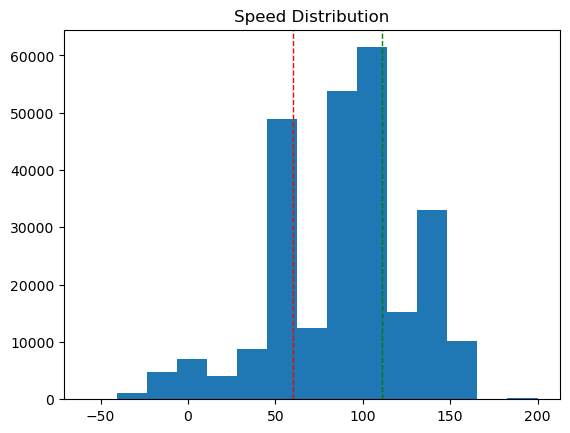


 ------- SPEED PERCENTILES -------
25th percentile value: 60.0
75th percentile value: 111.0


In [28]:
speed_25th_perc, speed_75th_perc = get_dist_and_percentiles(df, stats="speed")
print("\n ------- SPEED PERCENTILES -------")
print(f"25th percentile value: {speed_25th_perc}")
print(f"75th percentile value: {speed_75th_perc}")

##### Number of fast and slow Pokemon per team

The below function assigns number values to the number of fast or slow Pokemon per team.

Fast Pokemon are defined as those with speed stats at or above the 75 percentile in our data (i.e. 116). Slow Pokemon are defined as those with speed stats at or below the 25th percentile in our data (i.e. 60).

In [30]:
def speed_tier_counts(row, speed_cols, player="p1", mode="fast"):

  speed_cols_player = [speed for speed in speed_cols if player in speed]

  speeds = row.loc[speed_cols_player]

  speed_tiered_pokemon = 0

  for pokemon_speed in speeds.values:
    # If mode is 'fast', look for fast Pokemon
    if mode == "fast":
      if pokemon_speed >= 116:
        speed_tiered_pokemon += 1
    # If mode is 'slow', look for slow Pokemon
    elif mode == "slow":
      if pokemon_speed <= 60:
        speed_tiered_pokemon += 1
    else:
      raise ValueError("Please enter either 'fast' or 'slow'.")

  return speed_tiered_pokemon

In [31]:
players = ["p1", "p2"]
speed_tiers = ["fast", "slow"]
speed_cols = [col for col in df.columns if "speed" in col]

# Find numbers of fast and slow Pokemon on each p1 and p2 team in our data
for player in players:
  for speed in speed_tiers:
    new_col = f"{player}_num_{speed}_mons"
    df[new_col] = df.apply(lambda x: speed_tier_counts(x, speed_cols, player=player, mode=speed), axis=1)

df.head()

,p1_species_1,p1_item_1,p1_ability_1,p1_move_1_1,p1_move_1_2,p1_move_1_3,p1_move_1_4,p1_species_2,p1_item_2,p1_ability_2,...,p1_avg_sp_def,p2_avg_sp_def,diff_avg_sp_def,p1_avg_speed,p2_avg_speed,diff_avg_speed,p1_num_fast_mons,p1_num_slow_mons,p2_num_fast_mons,p2_num_slow_mons
0,Amoonguss,RockyHelmet,Regenerator,SludgeBomb,Spore,RagePowder,Protect,Calyrex-Shadow,FocusSash,AsOneSpectrier,...,89.000000,96.833333,-7.833333,102.500000,92.166667,10.333333,3,1,1,2
1,Ditto,ChoiceScarf,Imposter,Transform,NaN,NaN,NaN,Flutter Mane,BoosterEnergy,Protosynthesis,...,90.333333,90.000000,0.333333,86.833333,113.666667,-26.833333,2,2,2,0
2,Chien-Pao,FocusSash,SwordofRuin,IcicleCrash,SuckerPunch,ThroatChop,Protect,Kyogre,MysticWater,Drizzle,...,88.333333,85.833333,2.500000,111.000000,108.500000,2.500000,2,0,2,1
3,Amoonguss,RockyHelmet,Regenerator,Spore,RagePowder,SludgeBomb,Protect,Calyrex-Shadow,LifeOrb,AsOneSpectrier,...,88.833333,97.666667,-8.833333,100.666667,88.666667,12.000000,3,2,0,1
4,Calyrex-Ice,ClearAmulet,AsOneGlastrier,GlacialLance,HighHorsepower,TrickRoom,Protect,Iron Hands,AssaultVest,QuarkDrive,...,81.500000,94.833333,-13.333333,89.500000,82.500000,7.000000,1,1,1,3


#### Bulk-based Features

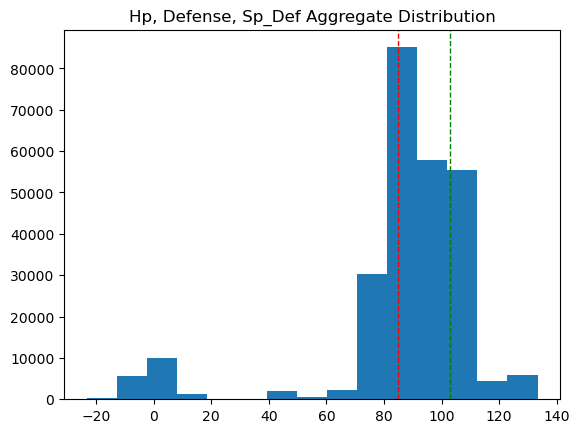


 ------- BULK PERCENTILES -------
25th percentile value: 85.0
75th percentile value: 103.0


In [33]:
speed_25th_perc, speed_75th_perc = get_dist_and_percentiles(df, stats=["hp", "defense", "sp_def"], agg_func="mean")
print("\n ------- BULK PERCENTILES -------")
print(f"25th percentile value: {speed_25th_perc}")
print(f"75th percentile value: {speed_75th_perc}")

In [34]:
def bulk_tier_counts(row, bulk_cols, mode="bulky"):
    # Reshape values into (6, 3): 6 Pokémon, 3 stats each
    bulk_stats = row[bulk_cols].values.reshape(6, 3)
    means = bulk_stats.mean(axis=1)  # mean for each Pokémon

    if mode == "bulky":
        return (means >= 105).sum()
    elif mode == "frail":
        return (means <= 86.34).sum()
    else:
        raise ValueError("Mode must be 'bulky' or 'frail'.")

In [35]:
players = ["p1", "p2"]
bulk_tiers = ["bulky", "frail"]
bulk_stats = ["hp", "defense", "sp_def"]

# For each player, get the relevant columns
player_bulk_cols = {
    player: [
        col for col in df.columns
        if player in col
        and any(col.endswith(f"_{stat}") for stat in bulk_stats)
        and not col.startswith(f"{player}_avg_")
    ]
    for player in players
}

# Find numbers of fast and slow Pokemon on each p1 and p2 team in our data
for player in players:
    for bulk in bulk_tiers:
        new_col = f"{player}_num_{bulk}_mons"
        df[new_col] = df.apply(
            lambda row: bulk_tier_counts(row, player_bulk_cols[player], mode=bulk),
            axis=1
        )

df.head()

,p1_species_1,p1_item_1,p1_ability_1,p1_move_1_1,p1_move_1_2,p1_move_1_3,p1_move_1_4,p1_species_2,p1_item_2,p1_ability_2,...,p2_avg_speed,diff_avg_speed,p1_num_fast_mons,p1_num_slow_mons,p2_num_fast_mons,p2_num_slow_mons,p1_num_bulky_mons,p1_num_frail_mons,p2_num_bulky_mons,p2_num_frail_mons
0,Amoonguss,RockyHelmet,Regenerator,SludgeBomb,Spore,RagePowder,Protect,Calyrex-Shadow,FocusSash,AsOneSpectrier,...,92.166667,10.333333,3,1,1,2,1,1,3,0
1,Ditto,ChoiceScarf,Imposter,Transform,NaN,NaN,NaN,Flutter Mane,BoosterEnergy,Protosynthesis,...,113.666667,-26.833333,2,2,2,0,1,3,2,3
2,Chien-Pao,FocusSash,SwordofRuin,IcicleCrash,SuckerPunch,ThroatChop,Protect,Kyogre,MysticWater,Drizzle,...,108.500000,2.500000,2,0,2,1,2,2,1,1
3,Amoonguss,RockyHelmet,Regenerator,Spore,RagePowder,SludgeBomb,Protect,Calyrex-Shadow,LifeOrb,AsOneSpectrier,...,88.666667,12.000000,3,2,0,1,2,2,3,2
4,Calyrex-Ice,ClearAmulet,AsOneGlastrier,GlacialLance,HighHorsepower,TrickRoom,Protect,Iron Hands,AssaultVest,QuarkDrive,...,82.500000,7.000000,1,1,1,3,2,1,4,0


#### Bulk-based Features

Note: As mixed attackers are increasingly rare in VGC, for 'power' we consider only each Pokemon's highest attacking stat.

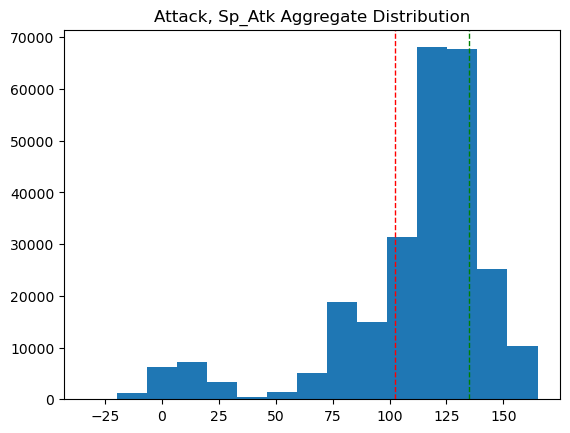


 ------- POWER PERCENTILES -------
25th percentile value: 102.5
75th percentile value: 135.0


In [37]:
power_25th_perc, power_75th_perc = get_dist_and_percentiles(df, stats=["attack", "sp_atk"], agg_func="max")

print("\n ------- POWER PERCENTILES -------")
print(f"25th percentile value: {power_25th_perc}")
print(f"75th percentile value: {power_75th_perc}")

In [38]:
def power_tier_counts(row, power_cols, mode="high"):
    # Reshape values into (6, 3): 6 Pokémon, 2 stats each
    power_stats = row[power_cols].values.reshape(6, 2)
    maxes = np.max(power_stats, axis=1)

    if mode == "high":
        return (maxes >= 135).sum()
    elif mode == "low":
        return (maxes <= 115).sum()
    else:
        raise ValueError("Mode must be 'high' or 'low'.")

In [39]:
players = ["p1", "p2"]
power_tiers = ["high", "low"]
power_stats = ["attack", "sp_atk"]

# For each player, get the relevant columns
player_power_cols = {
    player: [
        col for col in df.columns
        if player in col
        and any(col.endswith(f"_{stat}") for stat in power_stats)
        and not col.startswith(f"{player}_avg_")
    ]
    for player in players
}

# Find numbers of high and low power Pokemon on each p1 and p2 team in our data
for player in players:
    for power in power_tiers:
        new_col = f"{player}_num_{power}_power_mons"
        df[new_col] = df.apply(
            lambda row: power_tier_counts(row, player_power_cols[player], mode=power),
            axis=1
        )

df.head()

,p1_species_1,p1_item_1,p1_ability_1,p1_move_1_1,p1_move_1_2,p1_move_1_3,p1_move_1_4,p1_species_2,p1_item_2,p1_ability_2,...,p2_num_fast_mons,p2_num_slow_mons,p1_num_bulky_mons,p1_num_frail_mons,p2_num_bulky_mons,p2_num_frail_mons,p1_num_high_power_mons,p1_num_low_power_mons,p2_num_high_power_mons,p2_num_low_power_mons
0,Amoonguss,RockyHelmet,Regenerator,SludgeBomb,Spore,RagePowder,Protect,Calyrex-Shadow,FocusSash,AsOneSpectrier,...,1,2,1,1,3,0,2,1,3,1
1,Ditto,ChoiceScarf,Imposter,Transform,NaN,NaN,NaN,Flutter Mane,BoosterEnergy,Protosynthesis,...,2,0,1,3,2,3,2,3,2,0
2,Chien-Pao,FocusSash,SwordofRuin,IcicleCrash,SuckerPunch,ThroatChop,Protect,Kyogre,MysticWater,Drizzle,...,2,1,2,2,1,1,2,0,2,1
3,Amoonguss,RockyHelmet,Regenerator,Spore,RagePowder,SludgeBomb,Protect,Calyrex-Shadow,LifeOrb,AsOneSpectrier,...,0,1,2,2,3,2,2,1,4,1
4,Calyrex-Ice,ClearAmulet,AsOneGlastrier,GlacialLance,HighHorsepower,TrickRoom,Protect,Iron Hands,AssaultVest,QuarkDrive,...,1,3,2,1,4,0,2,2,4,1


### Type Based Feature Engineering

#### Type Diversity
Get metrics for the number of different types used on a team, as well as differences in type diversity between two teams!

In [42]:
# Example: Add type diversity (optional, but valuable!)
def count_team_types(row, prefix):
    type_cols = [f"{prefix}_species_{i}_type_{j}" for i in range(1,7) for j in [1,2]]
    return len(set([row[col] for col in type_cols if pd.notnull(row[col])]))

df['p1_type_diversity'] = df.apply(lambda row: count_team_types(row, 'p1'), axis=1)
df['p2_type_diversity'] = df.apply(lambda row: count_team_types(row, 'p2'), axis=1)
df['diff_type_diversity'] = df['p1_type_diversity'] - df['p2_type_diversity']

#### Type Matchup Score
Calculating a type matchup score based on the types used on each team. A higher score indicates a better type matchup.

In [44]:
# Type chart encoded as a dictionary of dictionaries
# Keys represent attacking types, dictionaries represent interactions defensive types
# Values not listed are neither super or not very effective (simply x1)

type_chart = {
    'Normal': {
        'Rock': 0.5, 'Ghost': 0.0, 'Steel': 0.5,
    },
    'Fire': {
        'Fire': 0.5, 'Water': 0.5, 'Grass': 2.0, 'Ice': 2.0, 'Bug': 2.0,
        'Rock': 0.5, 'Dragon': 0.5, 'Steel': 2.0,
    },
    'Water': {
        'Fire': 2.0, 'Water': 0.5, 'Grass': 0.5, 'Ground': 2.0, 'Rock': 2.0, 'Dragon': 0.5,
    },
    'Electric': {
        'Water': 2.0, 'Electric': 0.5, 'Grass': 0.5, 'Ground': 0.0, 'Flying': 2.0, 'Dragon': 0.5,
    },
    'Grass': {
        'Fire': 0.5, 'Water': 2.0, 'Grass': 0.5, 'Poison': 0.5, 'Ground': 2.0, 'Flying': 0.5,
        'Bug': 0.5, 'Rock': 2.0, 'Dragon': 0.5, 'Steel': 0.5,
    },
    'Ice': {
        'Fire': 0.5, 'Water': 0.5, 'Grass': 2.0, 'Ground': 2.0, 'Flying': 2.0, 'Dragon': 2.0,
        'Steel': 0.5,
    },
    'Fighting': {
        'Normal': 2.0, 'Ice': 2.0, 'Poison': 0.5, 'Flying': 0.5, 'Psychic': 0.5, 'Bug': 0.5,
        'Rock': 2.0, 'Ghost': 0.0, 'Dark': 2.0, 'Steel': 2.0, 'Fairy': 0.5,
    },
    'Poison': {
        'Grass': 2.0, 'Poison': 0.5, 'Ground': 0.5, 'Rock': 0.5, 'Ghost': 0.5, 'Steel': 0.0, 'Fairy': 2.0,
    },
    'Ground': {
        'Fire': 2.0, 'Electric': 2.0, 'Grass': 0.5, 'Poison': 2.0, 'Flying': 0.0, 'Bug': 0.5,
        'Rock': 2.0, 'Steel': 2.0,
    },
    'Flying': {
        'Electric': 0.5, 'Grass': 2.0, 'Fighting': 2.0, 'Bug': 2.0, 'Rock': 0.5, 'Steel': 0.5,
    },
    'Psychic': {
        'Fighting': 2.0, 'Poison': 2.0, 'Psychic': 0.5, 'Dark': 0.0, 'Steel': 0.5,
    },
    'Bug': {
        'Fire': 0.5, 'Grass': 2.0, 'Fighting': 0.5, 'Poison': 0.5, 'Flying': 0.5, 'Psychic': 2.0,
        'Ghost': 0.5, 'Dark': 2.0, 'Steel': 0.5, 'Fairy': 0.5,
    },
    'Rock': {
        'Fire': 2.0, 'Ice': 2.0, 'Fighting': 0.5, 'Ground': 0.5, 'Flying': 2.0, 'Bug': 2.0,
        'Steel': 0.5,
    },
    'Ghost': {
        'Normal': 0.0, 'Psychic': 2.0, 'Ghost': 2.0, 'Dark': 0.5,
    },
    'Dragon': {
        'Dragon': 2.0, 'Steel': 0.5, 'Fairy': 0.0,
    },
    'Dark': {
        'Fighting': 0.5, 'Psychic': 2.0, 'Ghost': 2.0, 'Dark': 0.5, 'Fairy': 0.5,
    },
    'Steel': {
        'Fire': 0.5, 'Water': 0.5, 'Electric': 0.5, 'Ice': 2.0, 'Rock': 2.0, 'Steel': 0.5, 'Fairy': 2.0,
    },
    'Fairy': {
        'Fire': 0.5, 'Fighting': 2.0, 'Poison': 0.5, 'Dragon': 2.0, 'Dark': 2.0, 'Steel': 0.5,
    }
}

In [45]:
# Function to get all types from a given player
def get_team_pokemon_types(row, player="p1"):
    pokemon = []
    for i in range(1, 7):
        t1 = row.get(f'{player}_species_{i}_type_1', None)
        t2 = row.get(f'{player}_species_{i}_type_2', None)
        # output is a list of tuples, with each tuple representing the type(s) of a Pokemon
        pokemon.append( (t1, t2) )
    return pokemon

In [46]:
# Function to calculate the effectiveness of a type on one or more defending types
def calc_effectiveness(attacking_type, defending_types, type_chart):
    mult = 1.0
    # for each type of a dual type, calculate against the types one by one and scale the multipliers
    for def_type in defending_types:
        if def_type:  # ignore None
            mult *= type_chart.get(attacking_type, {}).get(def_type, 1.0)
    return mult

In [47]:
# test all types on the attacking team against the defensive typings of each of the opponent's team

def pokemon_vs_team_score(attacker_types, defenders, type_chart):
    score = 0
    for atk_type in attacker_types:
        if atk_type is None:
            continue
        for def_types in defenders:
          # calculating type effectiveness and assigning a score to this
            eff = calc_effectiveness(atk_type, def_types, type_chart)
            if eff == 2.0:
                score += 1
            elif eff == 4.0:
                score += 2  # super-super effective (e.g. Electric vs Water/Flying)
            elif eff == 0.5:
                score -= 1
            elif eff == 0.25:
                score -= 2  # double resistance
            elif eff == 0.0:
                score -= 2  # immunity
    return score

In [48]:
# for each Pokemon on the attacking team, calculate type scores against each of the defending team's Pokemon
def team_vs_team_score(attacking_team, defending_team, type_chart):
    total = 0
    for attacker in attacking_team:
        total += pokemon_vs_team_score(attacker, defending_team, type_chart)
    return total

In [49]:

def compute_teamwise_matchup_scores(row, type_chart):
    p1_team = get_team_pokemon_types(row, "p1")
    p2_team = get_team_pokemon_types(row, "p2")
    p1_vs_p2 = team_vs_team_score(p1_team, p2_team, type_chart)
    p2_vs_p1 = team_vs_team_score(p2_team, p1_team, type_chart)
    return pd.Series({
        'teamwise_matchup_diff': p1_vs_p2 - p2_vs_p1
    })

In [50]:
df["p1_type_matchup_score"] = df.apply(
    lambda row: compute_teamwise_matchup_scores(row, type_chart),
    axis=1
)

In [51]:
df.head()

,p1_species_1,p1_item_1,p1_ability_1,p1_move_1_1,p1_move_1_2,p1_move_1_3,p1_move_1_4,p1_species_2,p1_item_2,p1_ability_2,...,p2_num_bulky_mons,p2_num_frail_mons,p1_num_high_power_mons,p1_num_low_power_mons,p2_num_high_power_mons,p2_num_low_power_mons,p1_type_diversity,p2_type_diversity,diff_type_diversity,p1_type_matchup_score
0,Amoonguss,RockyHelmet,Regenerator,SludgeBomb,Spore,RagePowder,Protect,Calyrex-Shadow,FocusSash,AsOneSpectrier,...,3,0,2,1,3,1,11,10,1,-3
1,Ditto,ChoiceScarf,Imposter,Transform,NaN,NaN,NaN,Flutter Mane,BoosterEnergy,Protosynthesis,...,2,3,2,3,2,0,8,9,-1,-4
2,Chien-Pao,FocusSash,SwordofRuin,IcicleCrash,SuckerPunch,ThroatChop,Protect,Kyogre,MysticWater,Drizzle,...,1,1,2,0,2,1,9,11,-2,-3
3,Amoonguss,RockyHelmet,Regenerator,Spore,RagePowder,SludgeBomb,Protect,Calyrex-Shadow,LifeOrb,AsOneSpectrier,...,3,2,2,1,4,1,11,11,0,0
4,Calyrex-Ice,ClearAmulet,AsOneGlastrier,GlacialLance,HighHorsepower,TrickRoom,Protect,Iron Hands,AssaultVest,QuarkDrive,...,4,0,2,2,4,1,8,10,-2,-4


### Move and Ability Features

In [53]:
WEATHER_SETTER_ABILITIES = {
    'Drought',          # Sun
    'Drizzle',          # Rain
    'Sand Stream',      # Sand
    'Snow Warning',     # Snow
    'Orichalcum Pulse', # Harsh Sun (Koraidon)
}

WEATHER_SETTER_MOVES = {
    'Sunny Day',    # Sun
    'Rain Dance',   # Rain
    'Sandstorm',    # Sand
    'Snowscape',    # Snow
}

SPEED_CONTROL_MOVES = {
    'Tailwind',       # Double Speed for 4 turns
    'Trick Room',     # Reverse move order for 5 turns
    'Icy Wind',       # Lowers opponents' Speed
    'Electroweb',     # Lowers opponents' Speed
    'Thunder Wave',   # Paralyze
    'Scary Face',     # Sharply lowers Speed
    'Rock Tomb',      # Lowers Speed
    'Bulldoze',       # Lowers Speed
    'String Shot',    # Sharply lowers Speed
    'Sticky Web',     # Lowers Speed on switch-in
}

PRIORITY_MOVES = {
    # +1 priority
    'Quick Attack', 'Aqua Jet', 'Bullet Punch', 'Ice Shard', 'Shadow Sneak',
    'Extreme Speed', 'Mach Punch', 'Vacuum Wave', 'Water Shuriken', 'Sucker Punch',
    'First Impression', 'Jet Punch', 'Baby-Doll Eyes', 'Fake Out', 'Accelerock',
    'Grassy Glide', 'Feint', 'Ally Switch', 'Wide Guard', 'Quick Guard', 'Crafty Shield',
    'Follow Me', 'Rage Powder', 'Helping Hand', 'Magic Coat', 'Detect', 'Protect',
    # +2 priority
    'Prankster'  # as an ability, not a move!
}

TERRAIN_SETTER_ABILITIES = {
    'Electric Surge',  # Electric Terrain
    'Grassy Surge',    # Grassy Terrain
    'Misty Surge',     # Misty Terrain
    'Psychic Surge',   # Psychic Terrain
    'Seed Sower',      # Grassy Terrain on hit
    'Hadron Engine',   # Electric Terrain on entry
}

TERRAIN_SETTER_MOVES = {
    'Electric Terrain',
    'Grassy Terrain',
    'Misty Terrain',
    'Psychic Terrain',
}

SPREAD_MOVES = {
    'Rock Slide', 'Heat Wave', 'Earthquake', 'Surf', 'Dazzling Gleam', 'Blizzard',
    'Discharge', 'Snarl', 'Icy Wind', 'Sludge Wave', 'Lava Plume', 'Muddy Water',
    'Hyper Voice', 'Eruption', 'Water Spout', 'Origin Pulse', 'Precipice Blades',
    'Expanding Force', 'Razor Leaf', 'Petal Blizzard', 'Air Cutter', 'Dark Pulse',
    'Dazzling Gleam', 'Glacial Lance', 'Freeze-Dry', 'Searing Shot'
}

KEY_ABILITY_INTIMIDATE = {'Intimidate'}

IMMUNITY_ABILITIES = {
    'Levitate', 'Flash Fire', 'Lightning Rod', 'Motor Drive', 'Storm Drain', 'Sap Sipper', 'Water Absorb', 'Volt Absorb', 'Dry Skin', 'Immunity', 'Water Veil', 'Soundproof'
}

SPEED_CONTROL_ABILITIES = {
    'Chlorophyll', 'Swift Swim', 'Sand Rush', 'Slush Rush', 'Surge Surfer', 'Unburden', 'Quick Feet', 'Speed Boost', 'Triage', 'Prankster'
}

WEATHER_BOOST_ABILITIES = {
    'Chlorophyll', 'Swift Swim', 'Sand Rush', 'Slush Rush', 'Solar Power', 'Rain Dish', 'Ice Body', 'Sand Force', 'Sand Veil', 'Leaf Guard', 'Dry Skin'
}

HAZARD_SETTER_MOVES = {
    'Stealth Rock', 'Spikes', 'Toxic Spikes', 'Sticky Web', 'Ceaseless Edge', 'Stone Axe'
}

HIGH_DAMAGE_MOVES = {
    'Explosion', 'Self-Destruct', 'Hyper Beam', 'Giga Impact', 'Draco Meteor', 'Hydro Pump', 'Fire Blast', 'Blizzard', 'Leaf Storm', 'Overheat', 'Fleur Cannon', 'Meteor Beam', 'Solar Beam', 'Solar Blade', 'Focus Blast', 'Close Combat', 'Brave Bird', 'Flare Blitz', 'Wood Hammer', 'Head Smash', 'Outrage', 'Petal Dance', 'Eruption', 'Water Spout'
}

RECOVERY_MOVES = {
    'Recover', 'Roost', 'Soft-Boiled', 'Milk Drink', 'Slack Off', 'Synthesis', 'Moonlight', 'Morning Sun', 'Shore Up', 'Aqua Ring', 'Life Dew', 'Heal Order', 'Strength Sap', 'Wish', 'Jungle Healing'
}

TRICK_ROOM_MOVES = {'Trick Room'}

ANTI_STATUS_MOVES = {'Imprison', 'Taunt'}

In [54]:
def has_ability(row, player, ability_set):
    for i in range(1, 7):
        ability = row.get(f"{player}_ability_{i}")
        if pd.notnull(ability) and ability in ability_set:
            return 1
    return 0

def has_move(row, player, move_set):
    for i in range(1, 7):
        for m in range(1, 5):
            move = row.get(f"{player}_move_{i}_{m}")
            if pd.notnull(move) and move in move_set:
                return 1
    return 0

def count_moves(row, player, move_set):
    count = 0
    for i in range(1, 7):
        for m in range(1, 5):
            move = row.get(f"{player}_move_{i}_{m}")
            if pd.notnull(move) and move in move_set:
                count += 1
    return count

In [55]:
ROLE_SETS = {
    'weather_setter_ability': {
        'set': WEATHER_SETTER_ABILITIES,
        'type': 'ability',
        'feature': 'has'  # Boolean (0/1)
    },
    'weather_setter_move': {
        'set': WEATHER_SETTER_MOVES,
        'type': 'move',
        'feature': 'has'  # Boolean (0/1)
    },
    'speed_control_move': {
        'set': SPEED_CONTROL_MOVES,
        'type': 'move',
        'feature': 'count'  # Count of moves on team
    },
    'priority_move': {
        'set': PRIORITY_MOVES,
        'type': 'move',
        'feature': 'has'
    },
    'terrain_setter_ability': {
        'set': TERRAIN_SETTER_ABILITIES,
        'type': 'ability',
        'feature': 'has'
    },
    'terrain_setter_move': {
        'set': TERRAIN_SETTER_MOVES,
        'type': 'move',
        'feature': 'has'
    },
    'spread_move': {
        'set': SPREAD_MOVES,
        'type': 'move',
        'feature': 'count'
    },
    'hazard_setter_move': {
        'set': HAZARD_SETTER_MOVES,
        'type': 'move',
        'feature': 'has'
    },
    'high_damage_move': {
        'set': HIGH_DAMAGE_MOVES,
        'type': 'move',
        'feature': 'count'
    },
    'recovery_move': {
        'set': RECOVERY_MOVES,
        'type': 'move',
        'feature': 'has'
    },
    'trick_room_move': {
        'set': TRICK_ROOM_MOVES,
        'type': 'move',
        'feature': 'has'
    }
}

In [56]:
for role, info in ROLE_SETS.items():
    role_set = info['set']
    set_type = info['type']
    feature_type = info['feature']
    for player in ['p1', 'p2']:
        col_name = f"{player}_{feature_type}_{role}"
        if set_type == 'ability':
            # Only one ability per Pokémon, so "has" is appropriate
            df[col_name] = df.apply(lambda row: has_ability(row, player, role_set), axis=1)
        elif set_type == 'move':
            if feature_type == 'has':
                df[col_name] = df.apply(lambda row: has_move(row, player, role_set), axis=1)
            elif feature_type == 'count':
                df[col_name] = df.apply(lambda row: count_moves(row, player, role_set), axis=1)

### Bag of Words Transformation (for Clustering)

Converting our DataFrame into a sparse bag of words data matrix on the level of teams.

In [58]:
TEAM_LEVEL_FEATURES = [
    # Stat/threshold counts
    "num_fast_mons", "num_slow_mons",
    "num_bulky_mons", "num_frail_mons",
    "num_high_power_mons", "num_low_power_mons",
    # Role-based booleans
    "has_weather_setter_ability",
    "has_weather_setter_move",
    "has_priority_move",
    "has_terrain_setter_ability",
    "has_terrain_setter_move",
    "has_hazard_setter_move",
    "has_recovery_move",
    "has_trick_room_move",
    # Role-based counts
    "count_speed_control_move",
    "count_spread_move",
    "count_high_damage_move",
]

In [59]:
def count_bow(row, player):
    counts = Counter()
    # Per Pokémon: categorical features only
    for i in range(1, 7):
        val = row.get(f"{player}_species_{i}")
        if pd.notnull(val): counts[f"species={val}"] += 1
        val = row.get(f"{player}_item_{i}")
        if pd.notnull(val): counts[f"item={val}"] += 1
        val = row.get(f"{player}_ability_{i}")
        if pd.notnull(val): counts[f"ability={val}"] += 1
        for m in range(1, 5):
            move = row.get(f"{player}_move_{i}_{m}")
            if pd.notnull(move): counts[f"move={move}"] += 1
        t1 = row.get(f"{player}_species_{i}_type_1")
        t2 = row.get(f"{player}_species_{i}_type_2")
        if pd.notnull(t1): counts[f"type={t1}"] += 1
        if pd.notnull(t2): counts[f"type={t2}"] += 1

    # Team-level features: encode as counts or booleans
    for k in TEAM_LEVEL_FEATURES:
        col = f"{player}_{k}"
        val = row.get(col)
        if pd.notnull(val):
            if k.startswith("has_"):
                counts[k] = int(bool(val))
            else:
                counts[k] = int(val)
    return counts

# Create bag-of-words columns for both players
df["p1_bow_counts"] = df.apply(lambda row: count_bow(row, "p1"), axis=1)
df["p2_bow_counts"] = df.apply(lambda row: count_bow(row, "p2"), axis=1)

# Combine into a single list for vectorization
combined_counters = pd.concat([
    df["p1_bow_counts"],
    df["p2_bow_counts"]
], ignore_index=True)

# Remove the BoW columns from the frame
df = df.drop(["p1_bow_counts", "p2_bow_counts"], axis=1)

# Get all possible features
all_features = set()
for c in combined_counters:
    all_features.update(c.keys())
all_features = sorted(all_features)

# Convert list of Counters to a DataFrame
bow_counts = np.zeros((len(combined_counters), len(all_features)), dtype=int)
for i, counter in enumerate(combined_counters):
    for j, feat in enumerate(all_features):
        bow_counts[i, j] = counter.get(feat, 0)

bow_counts_df = pd.DataFrame(bow_counts, columns=all_features)

# Show the resulting DataFrame
bow_counts_df.head()

,ability=Adaptability,ability=Aftermath,ability=AirLock,ability=Analytic,ability=AngerPoint,ability=AngerShell,ability=ArenaTrap,ability=ArmorTail,ability=AromaVeil,ability=AsOneGlastrier,...,type=Ghost,type=Grass,type=Ground,type=Ice,type=Normal,type=Poison,type=Psychic,type=Rock,type=Steel,type=Water
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,1,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,3,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,2
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,1,1,0,1,0
4,0,0,0,0,0,0,0,0,0,1,...,0,2,0,0,0,0,1,1,0,2


#### Removing Rare Features (Feature Reduction)

The problem with this approach is that we have a very sparse feature matrix. Rare features are unlikely to be of much use, and greatly increase dimensionality. Below, I reincode the bag of words matrix to remove any feature present in fewer than 1% of teams in our dataset.

In [61]:
# getting counds of the instances of each feature
feature_counts = bow_counts_df.sum(axis=0)

# setting minimum threshold to be 1% of the total teams
rarity_threshold = 0.01
min_count = len(bow_counts_df) * rarity_threshold

# identify rare features and their type (species, move, item, ability, type)
rare_features = set(feature_counts[feature_counts < min_count].index)

def get_feature_type(feat):
    if feat.startswith("species="):
        return "species"
    elif feat.startswith("move="):
        return "move"
    elif feat.startswith("item="):
        return "item"
    elif feat.startswith("ability="):
        return "ability"
    elif feat.startswith("type="):
        return "type"
    else:
        return None

# for features that fall below the threshold
# get their type (e.g. move, item, ability, species)
# encode the team as having a rare feature of that type
def remap_counter(counter):
    new_counter = Counter()
    for feat, count in counter.items():
        if feat in rare_features:
            feat_type = get_feature_type(feat)
            if feat_type is not None:
                new_feat = f"{feat_type}=__RARE__"
            else:
                new_feat = feat  # team-level stats, keep as-is
            new_counter[new_feat] += count
        else:
            new_counter[feat] += count
    return new_counter

# remap our original bow counters
remapped_counters = [remap_counter(c) for c in combined_counters]

# build new BoW DataFrame with rare features removed and rare buckets added
all_features = set()
for c in remapped_counters:
    all_features.update(c.keys())
all_features = sorted(all_features)

# convert remapped counters to DataFrame
bow_counts = np.zeros((len(remapped_counters), len(all_features)), dtype=int)
for i, counter in enumerate(remapped_counters):
    for j, feat in enumerate(all_features):
        bow_counts[i, j] = counter.get(feat, 0)

bow_counts_df_final = pd.DataFrame(bow_counts, columns=all_features)

# Show the resulting DataFrame
bow_counts_df_final.head()

,ability=ArmorTail,ability=AsOneGlastrier,ability=AsOneSpectrier,ability=BeadsofRuin,ability=Chlorophyll,ability=Commander,ability=DauntlessShield,ability=Defiant,ability=Drizzle,ability=Drought,...,type=Ghost,type=Grass,type=Ground,type=Ice,type=Normal,type=Poison,type=Psychic,type=Rock,type=Steel,type=Water
0,0,0,1,0,0,0,1,0,0,0,...,1,1,0,1,0,1,1,0,1,1
1,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,3,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,0,0,1,2
3,0,0,1,0,0,0,1,0,0,0,...,1,1,0,1,0,1,1,0,1,0
4,0,1,0,0,0,0,0,0,1,0,...,0,2,0,0,0,0,1,1,0,2


### Clustering

Below, we cluster using K-means. We then evaluate the optimal number of clusters using the elbow and silhouette score methods.

#### Simple K-means

#### Finding Ideal Cluster Count

The below code helps identify the ideal number of clusters for our data. Methods used are the K-means inertia "elbow" method (looking for the point at which inertia plateaus) and the Silhouette Score (higher is better).

In [65]:
# # NOTE: this cell takes 10+ minutes to run! Feel free to just look at the visualizations below if you don't want to rerun.

max_k = 15 # Try up to 15 clusters
inertias = [] # "Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided." - docs
sil_scores = []

for k in tqdm(range(2, max_k + 1), desc="Clustering (KMeans)", unit="k"):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    labels = kmeans.fit_predict(bow_counts_df_final)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(bow_counts_df_final, labels))

Clustering (KMeans):   0%|          | 0/14 [00:00<?, ?k/s]

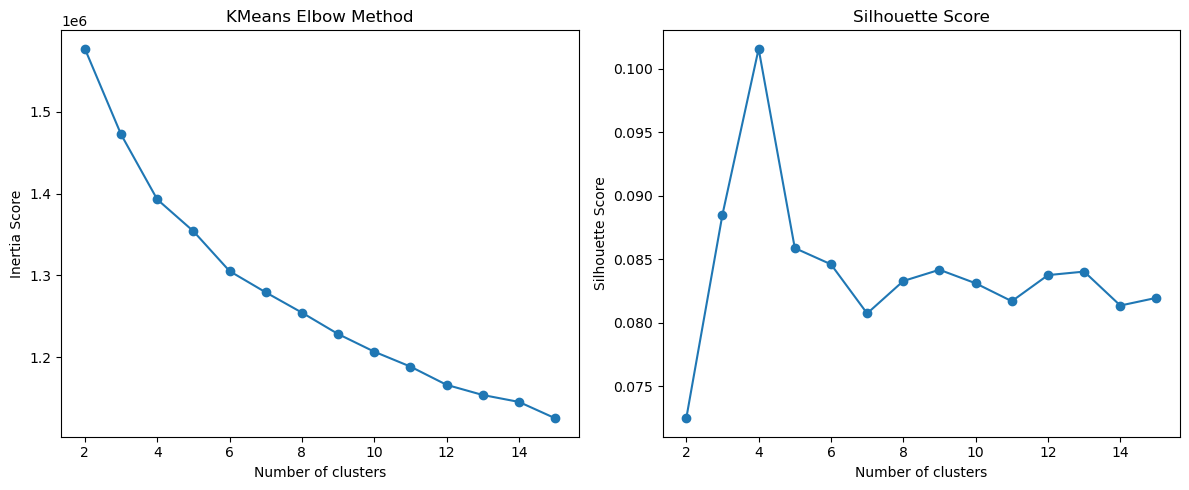

In [66]:
# Plot inertia (Elbow)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k + 1), inertias, marker='o')
plt.title("KMeans Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia Score")

# Plot silhouette score
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), sil_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

The closest we see to an elbow looking at the inertia score plot is when clusters=4 and clusters=6. As for silhouette score, we can see a clear peak at clusters=4.

#### Applying Clustering

In [73]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED)
labels = kmeans.fit_predict(bow_counts_df_final)
bow_counts_df_final["team_cluster"] = labels
# bow_counts_df_final['team_cluster'].head()

#### Exploring our clusters

In [76]:
feature_types = ["species", "move", "ability", "item"]
n_top = 6

for cluster_id in range(n_clusters):
    print(f"\n ------ Cluster {cluster_id} ------")
    cluster_mask = bow_counts_df_final["team_cluster"] == cluster_id

    for feature in feature_types:
        cols = [col for col in bow_counts_df_final.columns if col.startswith(f"{feature}=")]
        if not cols:
            continue

        global_mean = bow_counts_df_final[cols].mean()
        cluster_mean = bow_counts_df_final.loc[cluster_mask, cols].mean()
        uniqueness = cluster_mean - global_mean

        # Only keep features with positive uniqueness (overrepresented)
        unique = uniqueness[uniqueness > 0]
        if unique.empty:
            print(f"\nNo {feature}s are overrepresented in this cluster.")
            continue

        top = unique.sort_values(ascending=False).head(n_top)

        print(f"\nTop {n_top} overrepresented {feature} features: \n")
        for feat in top.index:
            print(f"{feat.split('=', 1)[1]} (cluster: {cluster_mean[feat]:.3f} | global: {global_mean[feat]:.3f} | unique: {uniqueness[feat]:+.3f})")


 ------ Cluster 0 ------

Top 6 overrepresented species features: 

__RARE__ (cluster: 2.053 | global: 0.537 | unique: +1.516)
Indeedee-F (cluster: 0.291 | global: 0.125 | unique: +0.167)
Smeargle (cluster: 0.109 | global: 0.027 | unique: +0.082)
Calyrex-Ice (cluster: 0.292 | global: 0.212 | unique: +0.080)
Kyogre (cluster: 0.204 | global: 0.127 | unique: +0.076)
Torkoal (cluster: 0.067 | global: 0.014 | unique: +0.053)

Top 6 overrepresented move features: 

__RARE__ (cluster: 2.851 | global: 0.731 | unique: +2.120)
TrickRoom (cluster: 0.994 | global: 0.711 | unique: +0.283)
FollowMe (cluster: 0.545 | global: 0.398 | unique: +0.146)
ExpandingForce (cluster: 0.245 | global: 0.109 | unique: +0.136)
TeraBlast (cluster: 0.174 | global: 0.075 | unique: +0.099)
IceBeam (cluster: 0.215 | global: 0.120 | unique: +0.094)

Top 6 overrepresented ability features: 

__RARE__ (cluster: 1.212 | global: 0.290 | unique: +0.922)
PsychicSurge (cluster: 0.296 | global: 0.125 | unique: +0.172)
Drizzle (

In [78]:
# Adding these clusters back to original df

half = len(bow_counts_df_final) // 2

df["p1_team_cluster"] = bow_counts_df_final["team_cluster"].iloc[:half].values
df["p2_team_cluster"] = bow_counts_df_final["team_cluster"].iloc[half:].values

#### Cluster Matchup Feature

In [83]:
# simple string feature indicating which cluster is facing which.
# could be useful for our later modeling
df['cluster_pair'] = df["p1_team_cluster"].astype(str) + "_" + df["p2_team_cluster"].astype(str)

In [85]:
# Export processed DataFrame with cluster labels

df.to_csv("battle_data_w_stat_features_and_cls_labels.csv", index=False)

## Jackson's approach to Modeling Testing

##Filter by ratings

In [89]:
# Define quantiles for low and high skill
low_q = 0.33
high_q = 0.66

low_thresh = df['rating'].quantile(low_q)
high_thresh = df['rating'].quantile(high_q)

df_low = df[df['rating'] <= low_thresh]
df_high = df[df['rating'] >= high_thresh]
df_all = df[df['rating'].notna()]  # Filter out rows with missing ratings for fair comparison

print(f"Low skill ≤ {low_thresh:.1f} | High skill ≥ {high_thresh:.1f}")
print(f"Low skill games: {len(df_low)}, High skill games: {len(df_high)}, All: {len(df_all)}")

Low skill ≤ 1174.0 | High skill ≥ 1283.0
Low skill games: 2562, High skill games: 2662, All: 7759


## Modeling by Player Skill (Rating Quantiles)

Below, we fit and evaluate models for low skill, high skill, and all players based on rating quantiles, to see how feature importance changes with player skill.


In [92]:
def fit_and_plot_feature_importance(df_group, diff_features, title_suffix=''):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score
    import matplotlib.pyplot as plt
    import pandas as pd

    # Drop NA rows for modeling
    model_df = df_group.dropna(subset=diff_features + ['p1_win'])
    X = model_df[diff_features]
    y = model_df['p1_win']

    if X.empty or y.nunique() < 2:
        print(f"Not enough data for {title_suffix}")
        return

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    # Plot feature importance
    feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    feature_importances.plot.bar()
    plt.title(f"Feature Importance {title_suffix}\nAccuracy: {acc:.3f}")
    plt.tight_layout()
    plt.show()


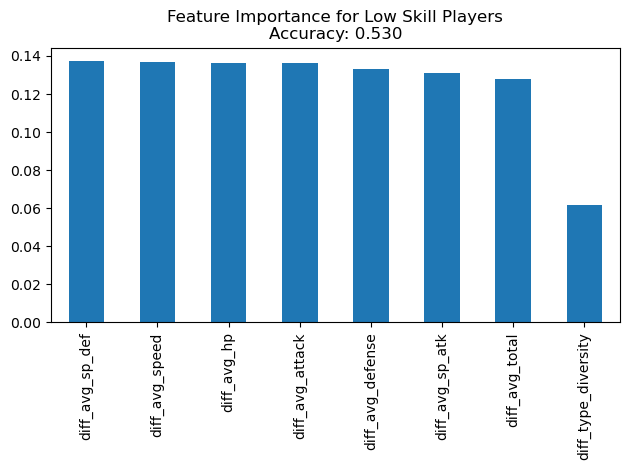

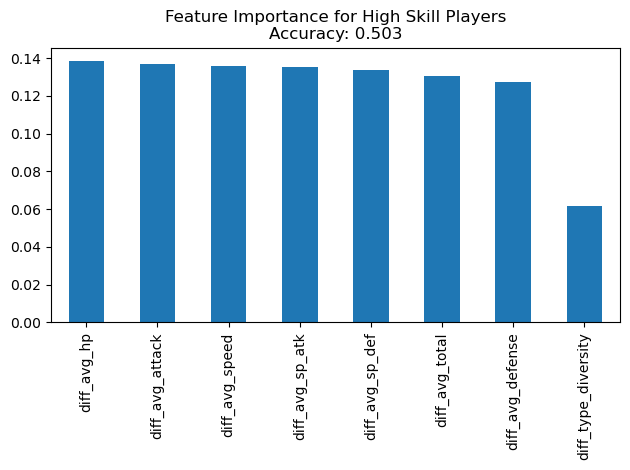

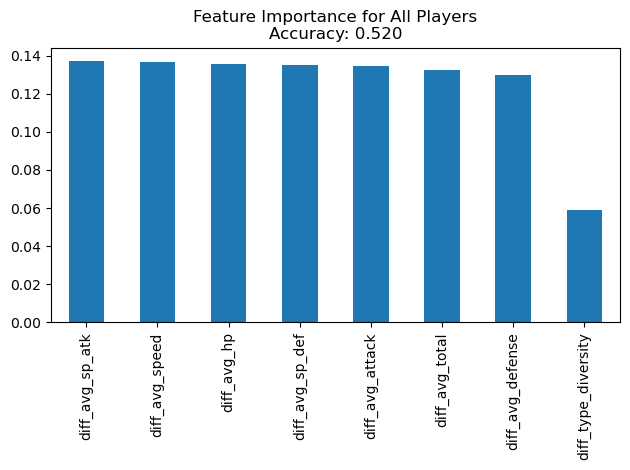

In [94]:
# Your feature selection (adjust as needed)
diff_features = [col for col in df.columns if 'diff' in col]

# Run for each group
fit_and_plot_feature_importance(df_low, diff_features, 'for Low Skill Players')
fit_and_plot_feature_importance(df_high, diff_features, 'for High Skill Players')
fit_and_plot_feature_importance(df_all, diff_features, 'for All Players')


#Build a modeling dataframe

In [96]:
#collect all differential features
diff_features = [col for col in df.columns if 'diff' in col]
print(diff_features)

#select the 'diff' features as X, outcome as Y
X = df[diff_features]
y = df['p1_win']

['diff_avg_total', 'diff_avg_hp', 'diff_avg_attack', 'diff_avg_defense', 'diff_avg_sp_atk', 'diff_avg_sp_def', 'diff_avg_speed', 'diff_type_diversity']


#Train-test split

In [98]:
from sklearn.model_selection import train_test_split
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=RANDOM_SEED, stratify=y
)

#Classifier training

In [103]:
from sklearn.ensemble import RandomForestClassifier
n_estimators = 100
clf = RandomForestClassifier(n_estimators=n_estimators, random_state=RANDOM_SEED)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#Evaluate Performance

In [105]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.49583453030738295
Confusion Matrix:
 [[897 846]
 [909 829]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.51      1743
           1       0.49      0.48      0.49      1738

    accuracy                           0.50      3481
   macro avg       0.50      0.50      0.50      3481
weighted avg       0.50      0.50      0.50      3481



Feature Importance Measures

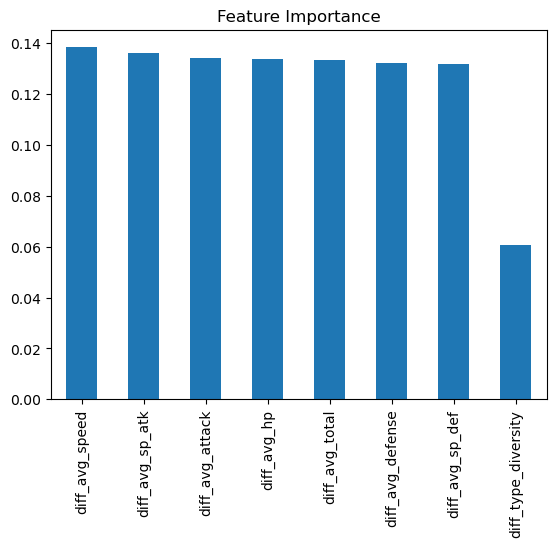

In [107]:
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot.bar()
plt.title("Feature Importance")
plt.show()


['diff_avg_total', 'diff_avg_hp', 'diff_avg_attack', 'diff_avg_defense', 'diff_avg_sp_atk', 'diff_avg_sp_def', 'diff_avg_speed', 'diff_type_diversity', 'cluster_diff', 'diff_unique_species']
Accuracy: 0.5243664717348928
Confusion Matrix:
 [[157 107]
 [137 112]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.59      0.56       264
           1       0.51      0.45      0.48       249

    accuracy                           0.52       513
   macro avg       0.52      0.52      0.52       513
weighted avg       0.52      0.52      0.52       513



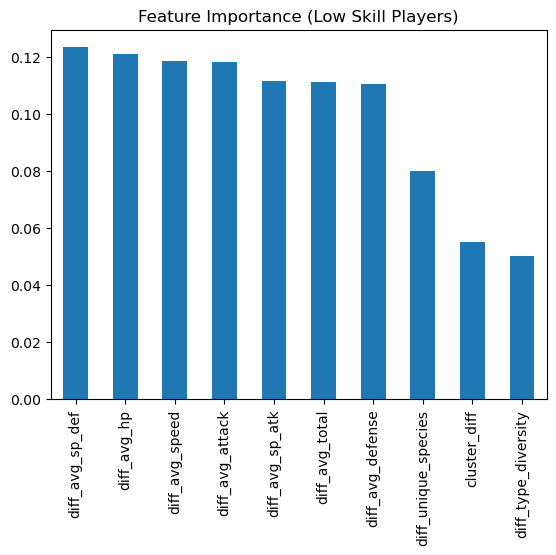

In [108]:
# prompt: repeat all previous analyses, this time only filtering by low ELO players
df_low = df[df['rating'] <= low_thresh].copy()
df_low['cluster_diff'] = df_low['p1_team_cluster'] - df_low['p2_team_cluster']

# Unique species diff (keep)
p1_species_cols = [col for col in df_low.columns if 'p1_species_' in col]
p2_species_cols = [col for col in df_low.columns if 'p2_species_' in col]
df_low['p1_unique_species'] = df_low[p1_species_cols].nunique(axis=1)
df_low['p2_unique_species'] = df_low[p2_species_cols].nunique(axis=1)
df_low['diff_unique_species'] = df_low['p1_unique_species'] - df_low['p2_unique_species']

# Stat diffs: Loop through stats for more features!
stats = ['total', 'hp', 'attack', 'defense', 'sp_atk', 'sp_def', 'speed']
for stat in stats:
    p1_cols = [col for col in df_low.columns if col.startswith('p1_species_') and col.endswith(f'_{stat}')]
    p2_cols = [col for col in df_low.columns if col.startswith('p2_species_') and col.endswith(f'_{stat}')]
    df_low[f'p1_avg_{stat}'] = df_low[p1_cols].mean(axis=1)
    df_low[f'p2_avg_{stat}'] = df_low[p2_cols].mean(axis=1)
    df_low[f'diff_avg_{stat}'] = df_low[f'p1_avg_{stat}'] - df_low[f'p2_avg_{stat}']

# Example: Add type diversity (optional, but valuable!)
def count_team_types(row, prefix):
    type_cols = [f"{prefix}_species_{i}_type_{j}" for i in range(1,7) for j in [1,2]]
    return len(set([row[col] for col in type_cols if pd.notnull(row[col])]))

df_low['p1_type_diversity'] = df_low.apply(lambda row: count_team_types(row, 'p1'), axis=1)
df_low['p2_type_diversity'] = df_low.apply(lambda row: count_team_types(row, 'p2'), axis=1)
df_low['diff_type_diversity'] = df_low['p1_type_diversity'] - df_low['p2_type_diversity']


#Build a modeling dataframe
#collect all differential features
diff_features = [col for col in df_low.columns if 'diff' in col]
print(diff_features)

#select the 'diff' features as X, outcome as Y
X = df_low[diff_features]
y = df_low['p1_win']
#Train-test split
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=RANDOM_SEED, stratify=y
)
#Classifier training
n_estimators = 100
clf = RandomForestClassifier(n_estimators=n_estimators, random_state=RANDOM_SEED)
clf.fit(X_train, y_train)
#Evaluate Performance

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance Measures
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot.bar()
plt.title("Feature Importance (Low Skill Players)")
plt.show()